In [ ]:
#임포트

import numpy as np
import librosa
import librosa.display
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import soundfile as sf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Bidirectional, GRU
from tensorflow.keras.layers import Dropout, BatchNormalization
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from scipy.signal import fftconvolve
from scipy.io import wavfile



In [ ]:
# 데이터 로드 및 전처리

hop_length=512
n_fft=2048

def stft_transform(file_path):
    audio, sr = librosa.load(file_path, sr=44100)
    stft_data = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length)
    magnitude, phase = librosa.magphase(stft_data)
    return magnitude, phase

def find_length(file_path):
    audio, sr = librosa.load(file_path, sr=44100)
    length = len(audio) / sr
    return length


external_file_path = 'out_noise70dB_iphone12mini.wav'
internal_file_path = 'in_noise50dB_iphone12mini.wav'

length_1 = find_length(external_file_path)
length_2 = find_length(internal_file_path)
print(length_1)
print(length_2)

external_magnitude, _ = stft_transform(external_file_path)
internal_magnitude, _ = stft_transform(internal_file_path)

X_train = external_magnitude.T
y_train = internal_magnitude.T
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
y_train = y_train.reshape(y_train.shape[0], 1, y_train.shape[1])




50.52362811791383
50.52362811791383
Epoch 1/20
272/272 [==============================] - 14s 11ms/step - loss: 1.4336
Epoch 2/20
272/272 [==============================] - 3s 10ms/step - loss: 0.0026
Epoch 3/20
272/272 [==============================] - 3s 10ms/step - loss: 0.0020
Epoch 4/20
272/272 [==============================] - 3s 12ms/step - loss: 0.0020
Epoch 5/20
272/272 [==============================] - 3s 11ms/step - loss: 0.0019
Epoch 6/20
272/272 [==============================] - 3s 10ms/step - loss: 0.0019
Epoch 7/20
272/272 [==============================] - 3s 10ms/step - loss: 0.0019
Epoch 8/20
272/272 [==============================] - 3s 12ms/step - loss: 0.0019
Epoch 9/20
272/272 [==============================] - 3s 11ms/step - loss: 0.0019
Epoch 10/20
272/272 [==============================] - 3s 10ms/step - loss: 0.0019
Epoch 11/20
272/272 [==============================] - 3s 10ms/step - loss: 0.0019
Epoch 12/20
272/272 [==============================] - 3s 1

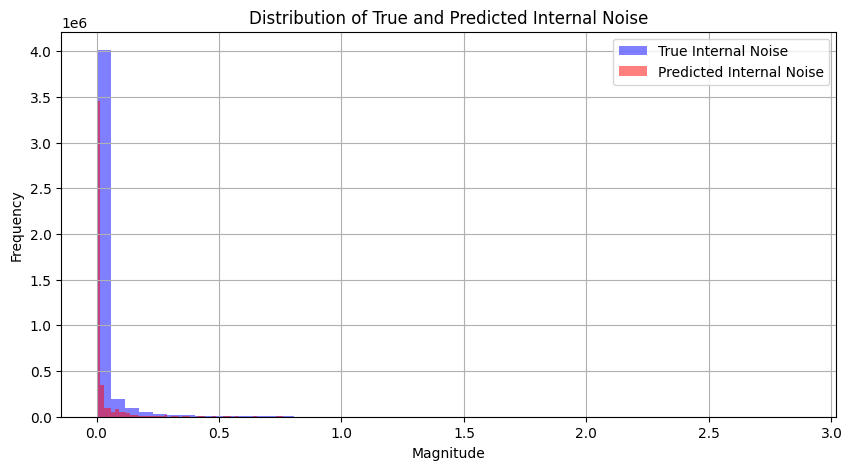

50.52362811791383
136/136 [==============================] - 1s 4ms/step
예측된 내부 소음 WAV 파일이 저장되었습니다: predicted_internal_noise.wav


In [ ]:
#모델


model = Sequential()

#model.add(Dropout(0.5)) # Dropout 비율을 0.5로 설정

model.add(Bidirectional(LSTM(units=64, return_sequences=True,kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), input_shape=(1, X_train.shape[2]))))
model.add(BatchNormalization())  # 배치 정규화 추가
model.add(Dropout(0.2))  # Dropout 추가

model.add(Bidirectional(LSTM(32, return_sequences=True,kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01))))
model.add(BatchNormalization())  # 배치 정규화 추가
model.add(Dropout(0.2))  # Dropout 추가

model.add(Bidirectional(LSTM(16, return_sequences=True,kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01))))
model.add(BatchNormalization())  # 배치 정규화 추가
model.add(Dropout(0.2))  # Dropout 추가

model.add(Dense(y_train.shape[2], activation='tanh'))

# Early Stopping 적용
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)


model.compile(optimizer='RMSprop', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=20, batch_size=16, callbacks=[early_stopping])


#________________________________________________________
y_true_values = y_train.flatten()
predicted_magnitude_values = model.predict(X_train).flatten()

# 예측된 값을 복원하기 위해 역정규화 수행
#predicted_magnitude_values = min_max_denormalize(predicted_magnitude_values, y_train_min, y_train_max)

plt.figure(figsize=(10, 5))
plt.hist(y_true_values, bins=50, alpha=0.5, label='True Internal Noise', color='blue')
plt.hist(predicted_magnitude_values, bins=50, alpha=0.5, label='Predicted Internal Noise', color='red')

plt.title('Distribution of True and Predicted Internal Noise')
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

#________________________________________________________
#테스트 소음 로드

test_file_path = 'out_noise70dB_iphone13pro.wav'
test_magnitude, test_phase = stft_transform(test_file_path)
length_3 = find_length(test_file_path)
print(length_3)

X_test = test_magnitude.T
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
# 테스트 데이터에 대해서도 정규화를 수행
#X_test, X_test_min, X_test_min = min_max_normalize(X_test)
predicted_magnitude = model.predict(X_test)
predicted_magnitude = predicted_magnitude.T
predicted_magnitude = predicted_magnitude.reshape(predicted_magnitude.shape[0], predicted_magnitude.shape[2])

predicted_stft = predicted_magnitude * test_phase

def stft_inverse_transform(stft_data, sr, file_path, original_length):
    audio_length = int(original_length * sr)
    audio = librosa.istft(stft_data, n_fft=n_fft, hop_length=hop_length, length=audio_length)
    sf.write(file_path, audio, sr, format='WAV', endian='LITTLE', subtype='PCM_16')

output_file_path = 'predicted_internal_noise.wav'
sr = 44100
stft_inverse_transform(predicted_stft, sr, output_file_path, length_3)

print("예측된 내부 소음 WAV 파일이 저장되었습니다:", output_file_path)

#______________________________________________________________
#감소된 소음 출력을 위한 실제 내부 소음 로드
real_internal_noise_path = 'in_noise50dB_iphone13pro.wav'



In [ ]:
#소음 도출 모듈 ver3

#_____________________________________________________________________________________________
#상쇄시키기 위해 출력할 소음 제작 및 저장
def generate_anti_noise(predicted_noise):

    # 예측한 소음의 반대 위상의 소음 생성
    fs_pred,data_pred=wavfile.read(predicted_noise)
    reverse_data_pred=(data_pred*(-1)).astype(data_pred.dtype)

    # 조절된 데이터로 새 WAV 파일 작성
    wavfile.write('anti_noise.wav', fs_pred, reverse_data_pred)

    print("상쇄 소음 'a'의 WAV 파일이 저장되었습니다:")

# "a" 소음 생성
generate_anti_noise('predicted_internal_noise.wav')


#_____________________________________________________________________________________________
#상쇄된 결과 소음 제작 및 저장

from scipy.signal import correlate

def calculate_rms(data):
    return np.sqrt(np.mean(data**2))

def adjust_volume_level(source_file, target_file, output_file):
    fs_source, data_source = wavfile.read(source_file)
    fs_target, data_target = wavfile.read(target_file)

    # 데이터가 스테레오인 경우 모노로 변환
    if len(data_source.shape) == 2:
        data_source = np.mean(data_source, axis=1).astype(data_source.dtype)
    if len(data_target.shape) == 2:
        data_target = np.mean(data_target, axis=1).astype(data_target.dtype)

    # RMS 레벨 계산
    rms_source = calculate_rms(data_source)
    rms_target = calculate_rms(data_target)

    # 레벨 조절
    scaling_factor = rms_target / rms_source
    adjusted_data = (data_source * scaling_factor).astype(data_source.dtype)

    # 조절된 데이터로 새 WAV 파일 작성
    wavfile.write(output_file, fs_source, adjusted_data)
    print(f"레벨이 조절된 오디오 파일이 저장되었습니다: {output_file}")

def find_offset(signal1, signal2):
    # 상호 상관을 계산하여 지연 찾기
    correlation = correlate(signal1, signal2)
    delay = np.argmax(correlation) - len(signal1) + 1
    return delay

def synchronize_and_combine(realnoise, antinoise):
    fs_real, data_real = wavfile.read(realnoise)
    fs_anti, data_anti = wavfile.read(antinoise)

    # data_real이 스테레오인 경우 모노로 변환
    if len(data_real.shape) == 2:
        data_real = np.mean(data_real, axis=1).astype(data_real.dtype)

    # 동기화 지점 찾기
    delay = find_offset(data_real, data_anti)

    # 두 신호를 동기화
    if delay > 0:
        data_anti = np.pad(data_anti, (delay, 0), mode='constant')
    else:
        data_real = np.pad(data_real, (-delay, 0), mode='constant')

    # 두 오디오 파일의 길이가 다를 경우, 더 짧은 길이에 맞춤
    min_len = min(len(data_real), len(data_anti))
    data_combined = data_real[:min_len] + data_anti[:min_len]
    data_combined = data_combined.astype(data_combined.dtype)

    # 조절된 데이터로 새 WAV 파일 작성
    wavfile.write('reduced_noise_b.wav', fs_real, data_combined)
    print("상쇄된 결과의 소음 'b'의 WAV 파일이 저장되었습니다:")

# 소음 레벨 조절
adjust_volume_level('predicted_internal_noise.wav', 'in_noise50dB_iphone13pro.wav', 'adjusted_predicted_noise.wav')

# 조절된 소음 파일과 실제 내부 소음 합치기
synchronize_and_combine('in_noise50dB_iphone13pro.wav', 'adjusted_predicted_noise.wav')


상쇄 소음 'a'의 WAV 파일이 저장되었습니다:
레벨이 조절된 오디오 파일이 저장되었습니다: adjusted_predicted_noise.wav


<ipython-input-14-2636f25465c3>:30: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs_target, data_target = wavfile.read(target_file)
<ipython-input-14-2636f25465c3>:57: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs_real, data_real = wavfile.read(realnoise)


상쇄된 결과의 소음 'b'의 WAV 파일이 저장되었습니다:
